In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:

!pip install -U efficientnet

In [3]:
#!unzip /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA.zip -d /content/drive/MyDrive/image_tampering_detection/

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00008_nat10122_11773.jpg  
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00045_arc00046_10084.tif  
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00045_arc00071_10087.tif  
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00046_arc00045_10083.tif  
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00054_cha00085_11922.jpg  
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00071_arc00045_10085.tif  
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00073_arc00072_10267.tif  
  inflating: /content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/Tp/Tp_D_CRN_M_N_arc00088_arc00064_1

In [4]:
import os
import io
import cv2
import random
import itertools
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import Sequential
import efficientnet.keras as effnet
from keras.applications.vgg19 import VGG19
from keras.utils import to_categorical
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications.densenet import DenseNet201
from sklearn.metrics import confusion_matrix,classification_report
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization, AveragePooling2D, GlobalAveragePooling2D

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

In [7]:
#data loading
labels = ['Au', 'Tp']
image_size=128
X = []
Y = []

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/image_tampering_detection/CASIA2_DATA',label)
    for file in tqdm(os.listdir(trainPath)[:3000]):
        X.append(array(convert_to_ela_image(os.path.join(trainPath, file), 90).resize((128, 128))).flatten() / 255.0)
        Y.append(label)

X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

100%|██████████| 3000/3000 [01:49<00:00, 27.36it/s]


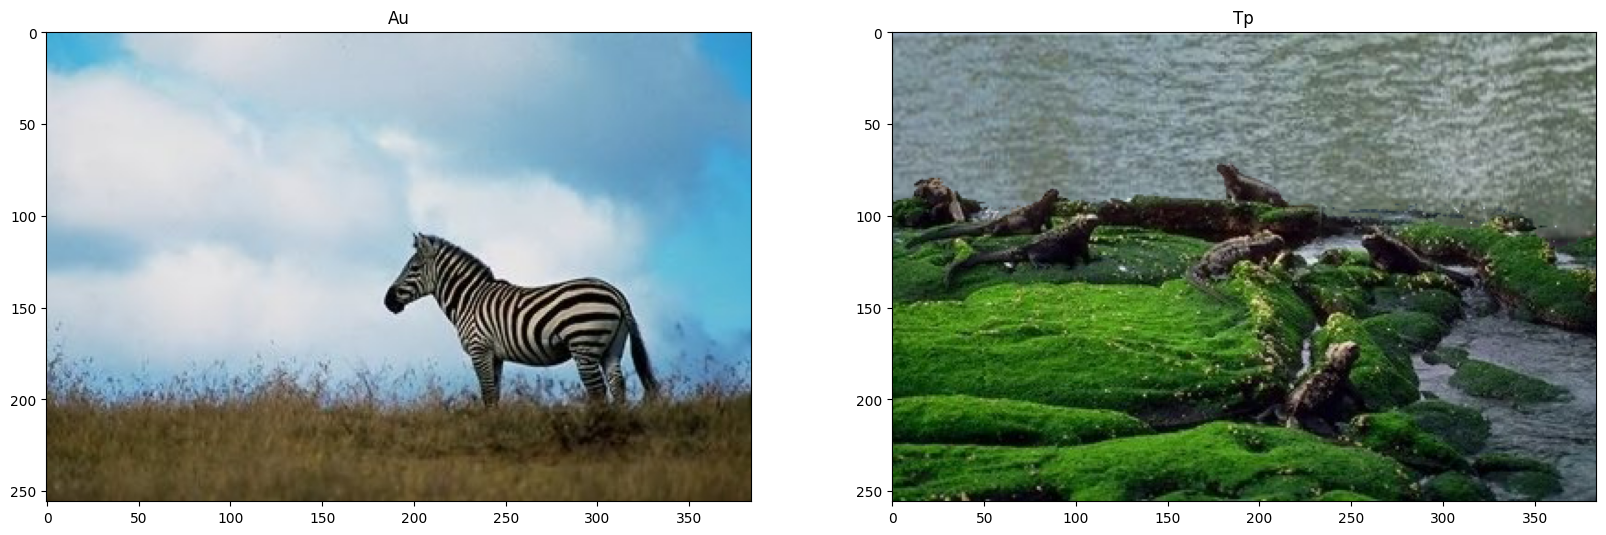

In [8]:

#Data Visualization
import matplotlib.image as mpimg
plt.figure(figsize = (20, 40))
image_count = 1
BASE_URL = '/content/drive/MyDrive/image_tampering_detection/CASIA2_DATA/'
for directory in labels:
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory)

<Axes: ylabel='count'>

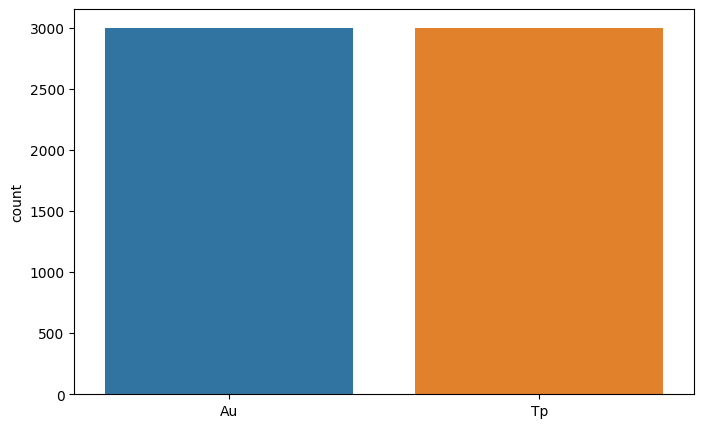

In [9]:
#count plot
plt.figure(figsize = (8, 5))
plt.xticks(rotation=0)
sns.countplot(x=Y,palette=sns.color_palette())

In [10]:
#converting categorical class to number
y = []
for i in Y:
  if i == 'Tp':
    y.append(1)
  else:
    y.append(0)

Y = y
Y = to_categorical(Y, 2)

In [11]:
print("shape of image: ",X.shape)
print("shape of target class: ",Y.shape)

shape of image:  (6000, 128, 128, 3)
shape of target class:  (6000, 2)


In [12]:
#splitting data into train and test with ratio of 80:10:10
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=5, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=5, shuffle=True)

#ELA_CNN

In [13]:
epochs = 10
batch_size = 8

In [14]:
#ELA_CNN
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='valid', activation='relu', input_shape=(128, 128, 3)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=None, padding='valid', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.50))
model.add(Dense(2, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 256)               7373056   
                                                        

In [19]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
608/608 [==============================] - 11s 10ms/step - loss: 0.4645 - accuracy: 0.7957 - val_loss: 0.3229 - val_accuracy: 0.8741
Epoch 2/10
608/608 [==============================] - 5s 9ms/step - loss: 0.3940 - accuracy: 0.8527 - val_loss: 0.2867 - val_accuracy: 0.8833
Epoch 3/10
608/608 [==============================] - 6s 10ms/step - loss: 0.3486 - accuracy: 0.8665 - val_loss: 0.3711 - val_accuracy: 0.8519
Epoch 4/10
608/608 [==============================] - 5s 9ms/step - loss: 0.2931 - accuracy: 0.8846 - val_loss: 0.2618 - val_accuracy: 0.8926
Epoch 5/10
608/608 [==============================] - 6s 10ms/step - loss: 0.2583 - accuracy: 0.8957 - val_loss: 0.2476 - val_accuracy: 0.9148
Epoch 6/10
608/608 [==============================] - 6s 9ms/step - loss: 0.2381 - accuracy: 0.9128 - val_loss: 0.2388 - val_accuracy: 0.9019
Epoch 7/10
608/608 [==============================] - 6s 9ms/step - loss: 0.2164 - accuracy: 0.9198 - val_loss: 0.3080 - val_accuracy: 0.8519
Ep

In [22]:
model.save("/content/drive/MyDrive/image_tampering_detection/Model/ELA_CNN.h5")

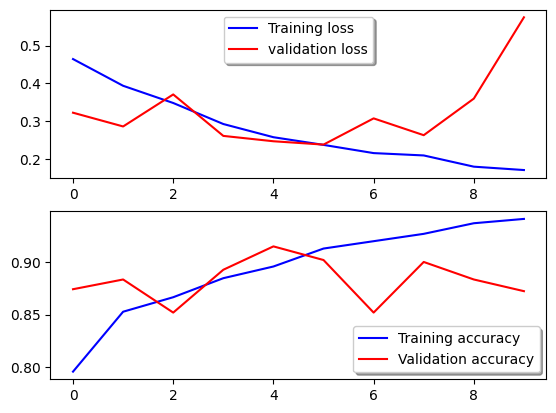

In [23]:
#Accuracy & Loss Graph
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss", axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
legend_ = ax[1].legend(loc='best', shadow=True)

In [24]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

19/19 [==============================] - 0s 9ms/step


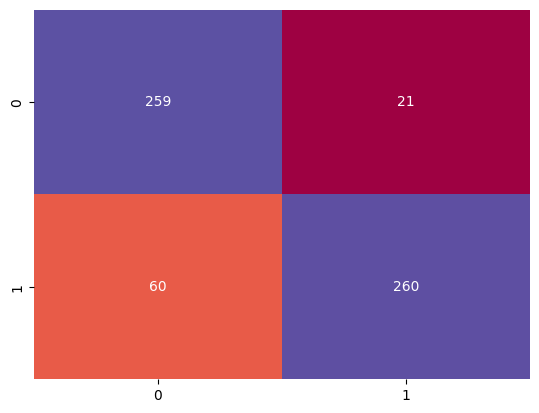

In [25]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
#plt.figure(figsize=(10,10))
sns.heatmap(confusion_mtx, annot = True, cbar = False, cmap=cm.get_cmap("Spectral"), fmt="d");

In [26]:
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       280
           1       0.93      0.81      0.87       320

    accuracy                           0.86       600
   macro avg       0.87      0.87      0.86       600
weighted avg       0.87      0.86      0.87       600

